# Using `dask` with Scanpy

`dask` is a popular out-of-core, distributed array processing library that scanpy is beginning to support.  Here we walk through a quick tutorial of using `dask` in a simple analysis task.

In [1]:
import numpy as np
import dask.distributed as dd
import dask.array as da
import scanpy as sc

sc.logging.print_header()

scanpy==1.10.0rc2.dev93+g31669098 anndata==0.11.0.dev78+g64ab900 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


For more information on using distributed computing via `dask`, please see their [documentation](https://docs.dask.org/en/stable/deploying-python.html).  For example, `dask` provides direct support for [slurm](https://jobqueue.dask.org/en/latest/).  In short, one needs to define both a cluster and a client to have some degree of control over the compute resources dask will use.

In [2]:
cluster = dd.LocalCluster(n_workers=1, threads_per_worker=1, processes=False)
client = dd.Client(cluster)

We'll convert the `X` representation to `dask`.  For more info on i/o from disk, please see the `anndata` tutorials, e.g. [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/anndata_dask_array.html) or [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/%7Bread%2Cwrite%7D_dispatched.html).  For now, simply converting `X` will be enough to demonstrate the functionality of scanpy with dask.

**_Important Note:_** At the moment, scanpy only works with dense, `np.array` chunks in `dask` arrays.  Sparse support is a work in progress, and this tutorial will be updated accordingly when possible. 


In [3]:
adata = sc.datasets.pbmc3k()
adata.X = da.from_array(np.array(adata.X.todense()), chunks=(500, adata.shape[1]))

In [4]:
adata.X

dask.array<array, shape=(2700, 32738), dtype=float32, chunksize=(500, 32738), chunktype=numpy.ndarray>

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

/Users/ilangold/Projects/Theis/scanpy/venv/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 337.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/ilangold/Projects/Theis/scanpy/venv/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 337.21 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/ilangold/Projects/Theis/scanpy/venv/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 337.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/ilangold/Projects/Theis/scanpy/venv/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 337.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and 

In [6]:
adata = adata[adata.obs["n_genes_by_counts"] < 2500, :]
adata = adata[adata.obs["pct_counts_mt"] < 5, :].copy()

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/Users/ilangold/Projects/Theis/scanpy/venv/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 337.34 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/ilangold/Projects/Theis/scanpy/venv/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 337.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


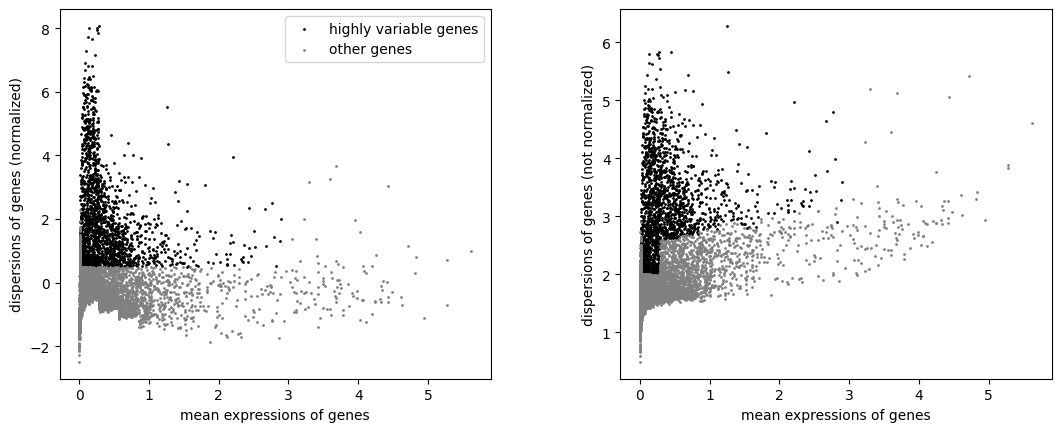

In [8]:
sc.pl.highly_variable_genes(adata)

The above plot should look extremely similar if not identical to that of the [original pbmc tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html), but instead we have used `dask` here.